In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats

import sys
sys.path.append("../")
import hmrf_gmm

In [3]:
phys_space = np.random.randn(1000,1)
feat_space = np.random.randn(1000,2)

# 1-D Example Data

## Create Model

In [4]:
np.random.seed(12345)
# define domain
latent_1D = np.zeros_like(phys_space[:,0])
dist = scipy.stats.bernoulli(0.01)

In [5]:
val = 0
for i in range(len(phys_space[:,0])):
    if dist.rvs():
        val = 1 - val
    latent_1D[i] = val

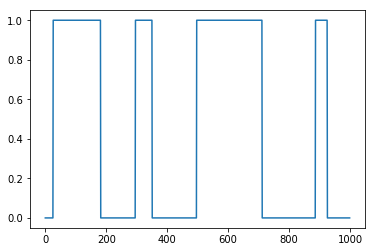

In [6]:
plt.plot(latent_1D);

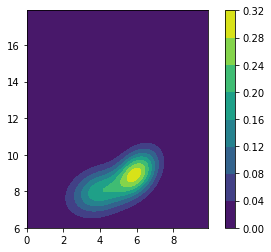

In [21]:
c1 = scipy.stats.multivariate_normal([6,9], [[0.5625, 0.225],[0.225, 0.675]])
c2 = scipy.stats.multivariate_normal([4,8], [[1.125, 0.225],[0.225, 0.675]])

x1, y1 = np.mgrid[-0:10:.1, 6:18:.1]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()

## Sample Data

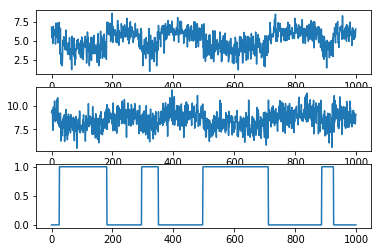

In [22]:
obs = np.empty((len(phys_space[:,0]), 2))
for i,l in enumerate(latent_1D):
    # generate a 2-d random vector at each point
    if l == 0:
        obs[i,:] = c1.rvs()
    elif l == 1:
        obs[i,:] = c2.rvs()
        
fig, ax = plt.subplots(3,1)
ax[0].plot(obs[:,0])
ax[1].plot(obs[:,1])
ax[2].plot(latent_1D)

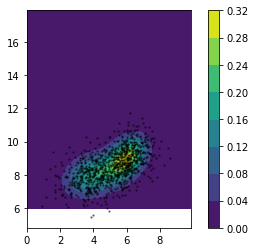

In [23]:
plt.contourf(x1, y1, c1.pdf(pos) + c2.pdf(pos)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()
plt.scatter(obs[:,0], obs[:,1], c='black', s=2, alpha=0.4)

## Try

In [24]:
ex1 = hmrf_gmm.HMRFGMM(phys_space, obs, n_gibbs=100)

In [19]:
ex1.data.head()

,x,f0,f1,color,label,neighbors,mrf_energy,self_energy
0,0.456036,5.202442,8.859371,0,0,[1],0,0
1,-1.937581,5.383180,9.167745,1,0,"[0, 2]",0,0
2,-2.745861,6.785315,8.214519,0,0,"[1, 3]",0,0
3,-1.922385,5.619458,8.603897,1,0,"[2, 4]",0,0
4,-0.859171,5.670223,8.495571,0,0,"[3, 5]",0,0


In [12]:
from sklearn import mixture

In [13]:
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')

In [14]:
clf.fit(ex1.data[["f0", "f1"]].values)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

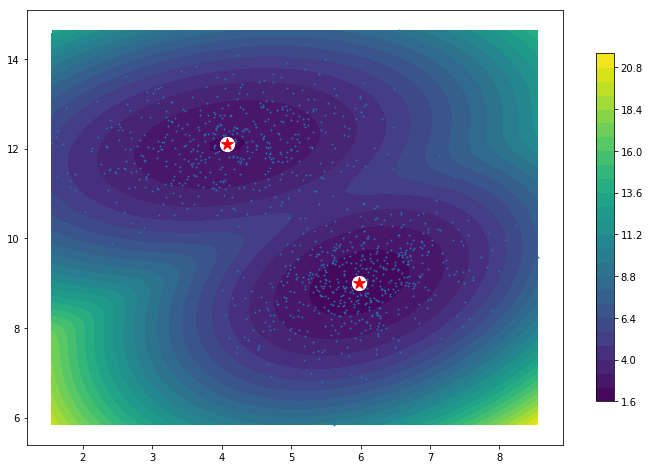

In [15]:
# display predicted scores by the model as a contour plot
from matplotlib.colors import LogNorm
plt.figure(figsize=(12,8))

x = np.linspace(np.min(ex1.data[["f0", "f1"]].values[:,0]), np.max(ex1.data[["f0", "f1"]].values[:,0]))
y = np.linspace(np.min(ex1.data[["f0", "f1"]].values[:,1]), np.max(ex1.data[["f0", "f1"]].values[:,1]))
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

# CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#                   levels=np.logspace(0, 3, 20))
CS = plt.contourf(X,Y,Z,30)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(ex1.data[["f0", "f1"]].values[:, 0], ex1.data[["f0", "f1"]].values[:, 1], .8)
# plot means
for cx,cy in clf.means_:
    plt.scatter(cx, cy, marker='o', s=200, c='w')
    plt.scatter(cx, cy, marker='*', s=150, c='r')

In [28]:
c

-0.49295598919024186

In [25]:
ex1.fit()

iter: 0 ; labels sum: 554
gibbs_count: 0
iter: 1 ; labels sum: 549
gibbs_count: 1
iter: 2 ; labels sum: 549
gibbs_count: 2
iter: 3 ; labels sum: 540
gibbs_count: 3
iter: 4 ; labels sum: 530
gibbs_count: 4
iter: 5 ; labels sum: 531
gibbs_count: 5
iter: 6 ; labels sum: 531
gibbs_count: 6
iter: 7 ; labels sum: 534
gibbs_count: 7
iter: 8 ; labels sum: 516
gibbs_count: 8
iter: 9 ; labels sum: 528
gibbs_count: 9
iter: 10 ; labels sum: 508
gibbs_count: 10
iter: 11 ; labels sum: 516
gibbs_count: 11
iter: 12 ; labels sum: 487
gibbs_count: 12
iter: 13 ; labels sum: 512
gibbs_count: 13
iter: 14 ; labels sum: 502
gibbs_count: 14
iter: 15 ; labels sum: 505
gibbs_count: 15
iter: 16 ; labels sum: 504
gibbs_count: 16
iter: 17 ; labels sum: 498
gibbs_count: 17
iter: 18 ; labels sum: 488
gibbs_count: 18
iter: 19 ; labels sum: 508
gibbs_count: 19
iter: 20 ; labels sum: 505
gibbs_count: 20
iter: 21 ; labels sum: 527
gibbs_count: 21
iter: 22 ; labels sum: 516
gibbs_count: 22
iter: 23 ; labels sum: 496
gibb

KeyboardInterrupt: 

In [30]:
np.shape(ex1.labels_all)

(50, 1000)

In [26]:
la = np.array(ex1.labels_all)

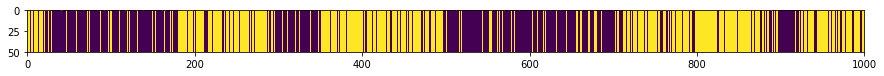

In [29]:
%matplotlib inline
plt.figure(figsize = (15,4))
plt.imshow(la)

In [ ]:
for label in range(data.n_labels):
    print(label)